In [8]:
import qiskit

In [9]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(3,3)

In [10]:
qc.measure(0,0)

In [11]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure(1,1)

In [12]:
print(qc)

     ┌───┐        
q_0: ┤ H ├──■─────
     └───┘┌─┴─┐┌─┐
q_1: ─────┤ X ├┤M├
          └───┘└╥┘
c: 2/═══════════╩═
                1 


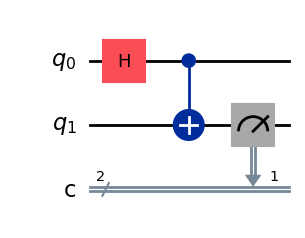

In [13]:
qc.draw(output = 'mpl')

In [14]:
from qiskit_aer.primitives import Sampler
sampler = Sampler()
shots = 1024
job = sampler.run(qc, shots=shots)
result = job.result()
print(result)

SamplerResult(quasi_dists=[{2: 0.5166015625, 0: 0.4833984375}], metadata=[{'shots': 1024, 'simulator_metadata': {'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000196583, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.001488084, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 8192, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'stabilizer', 'required_memory_mb': 0, 'fusion': {'enabled': False}}}])


Counts: {'10': 0.5166015625, '00': 0.4833984375}


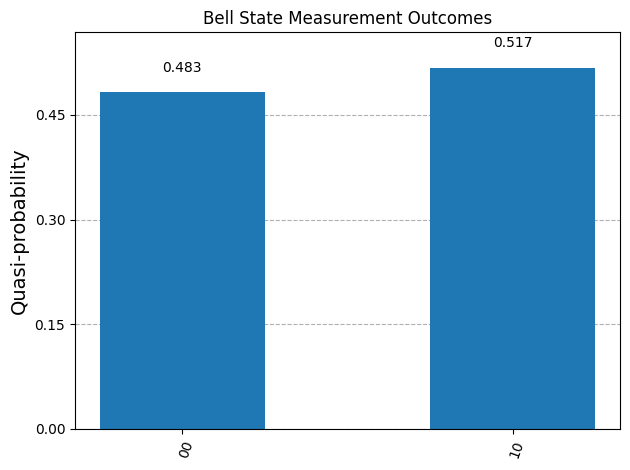

In [15]:
from qiskit.visualization import plot_histogram
counts = result.quasi_dists[0].binary_probabilities()
print(f"Counts: {counts}")
plot_histogram(counts, title = "Bell State Measurement Outcomes")

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel = "ibm_quantum_platform", token = "YOUR_IBM_QP_KEY", instance = "ibm_quantum", overwrite = True)

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
service = QiskitRuntimeService(channel = "ibm_quantum_platform")
backend = service.backend('ibm_brisbane')
pm = generate_preset_pass_manager(optimization_level = 1, backend = backend, translation_method = 'translator')
isa_circuit = pm.run(qc)
isa_circuit.draw(output = 'text')

global phase: 7π/4
          ┌────────┐ ┌────┐          ┌──────┐┌──────────┐┌────┐┌─────────┐   
q_0 -> 0 ─┤ Rz(-π) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├───
         ┌┴────────┴┐├────┤┌────────┐│  Ecr │├─────────┬┘├────┤├─────────┤┌─┐
q_1 -> 1 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤M├
         └──────────┘└────┘└────────┘└──────┘└─────────┘ └────┘└─────────┘└╥┘
    c: 2/══════════════════════════════════════════════════════════════════╩═
                                                                           1

In [20]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend)

job = sampler.run([isa_circuit])
print(f"Job ID: {job.job_id()}")
result = job.result()

Job ID: d28v01pogaas73cu83s0


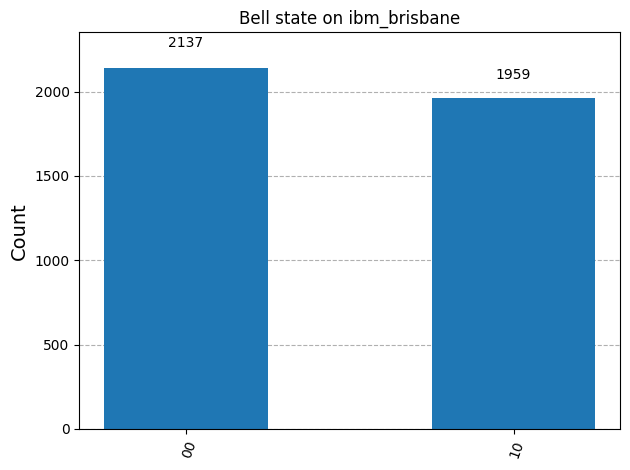

In [22]:
real_counts = result[0].data.c.get_counts()
plot_histogram(real_counts, title = f"Bell state on {backend.name}")

In [23]:
import numpy as np
from qiskit import QuantumCircuit

n = 3
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.mcx(list(range(n)), n)
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle_gate = balanced_oracle.to_gate()
balanced_oracle_gate.name = "Balanced Oracle"

constant_oracle = QuantumCircuit(n+1)
constant_oracle.x(n)
constant_oracle_gate = constant_oracle.to_gate()
constant_oracle_gate.name = "Constant Oracle"

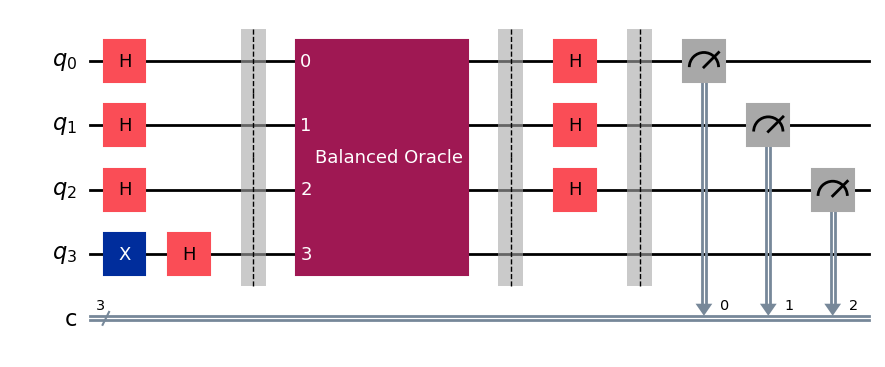

In [24]:
dj_circuit = QuantumCircuit(n+1, n)
dj_circuit.h(range(n))
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.barrier()

dj_circuit.append(balanced_oracle_gate, range(n+1))
dj_circuit.barrier()

dj_circuit.h(range(n))
dj_circuit.barrier()

dj_circuit.measure(range(n), range(n))
dj_circuit.draw(output = 'mpl')

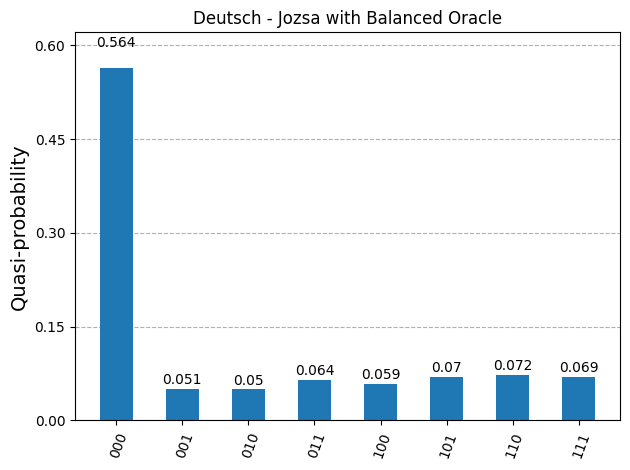

In [26]:
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram

sampler = Sampler()
job = sampler.run(dj_circuit, shots = 1024)
result = job.result()

counts = result.quasi_dists[0].binary_probabilities()
plot_histogram(counts, title = "Deutsch - Jozsa with Balanced Oracle")

In [28]:
pm = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend,
    translation_method='translator'
)
isa_circuit = pm.run(dj_circuit)
print("Transpilation complete.")

Transpilation complete.


In [29]:
print("Sending job to the backend...")
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
print(f"Job ID: {job.job_id()}")
result = job.result()
print("Job finished successfully.")

Sending job to the backend...
Job ID: d28vfn1ogaas73cu8i8g
Job finished successfully.


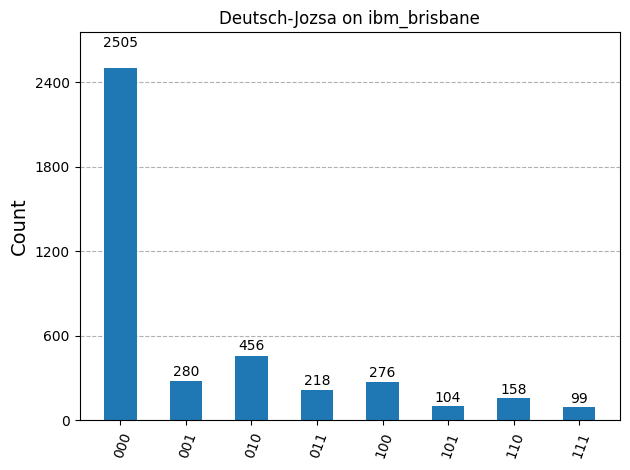

In [30]:
from qiskit.visualization import plot_histogram
dj_counts = result[0].data.c.get_counts()
plot_histogram(dj_counts, title=f"Deutsch-Jozsa on {backend.name}")